In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 15
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

# Build base name
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"

In [3]:
df = pd.read_pickle(RESAMPLED_FILE_PATH)
df.head()

,timestamp,open,high,low,close,volume,spread
0,2020-01-01 22:00:00,108.7580,108.7700,108.6495,108.7450,2.840570e+06,0.025989
1,2020-01-01 22:15:00,108.7450,108.7480,108.6290,108.7130,4.088100e+05,0.061481
2,2020-01-01 22:30:00,108.7135,108.7140,108.6740,108.6820,6.953400e+05,0.023646
3,2020-01-01 22:45:00,108.6820,108.6925,108.6820,108.6925,4.337400e+05,0.027363
4,2020-01-01 23:00:00,108.6910,108.6910,108.6050,108.6610,1.149910e+06,0.007992


## Datetime conversion

Dukascopy use UTC timezone

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df = df.sort_values('timestamp').reset_index(drop=True)

In [5]:
df

,timestamp,open,high,low,close,volume,spread
0,2020-01-01 22:00:00+00:00,108.7580,108.7700,108.6495,108.7450,2.840570e+06,0.025989
1,2020-01-01 22:15:00+00:00,108.7450,108.7480,108.6290,108.7130,4.088100e+05,0.061481
2,2020-01-01 22:30:00+00:00,108.7135,108.7140,108.6740,108.6820,6.953400e+05,0.023646
3,2020-01-01 22:45:00+00:00,108.6820,108.6925,108.6820,108.6925,4.337400e+05,0.027363
4,2020-01-01 23:00:00+00:00,108.6910,108.6910,108.6050,108.6610,1.149910e+06,0.007992
...,...,...,...,...,...,...,...
124041,2024-12-30 22:45:00+00:00,156.9225,156.9225,156.8825,156.8900,5.675900e+05,0.049048
124042,2024-12-30 23:00:00+00:00,156.8955,157.0250,156.8650,157.0205,2.453130e+06,0.024706
124043,2024-12-30 23:15:00+00:00,157.0230,157.0675,157.0110,157.0270,1.410730e+06,0.012274
124044,2024-12-30 23:30:00+00:00,157.0280,157.0520,156.9610,157.0335,4.898170e+06,0.011930


## Data Exloration

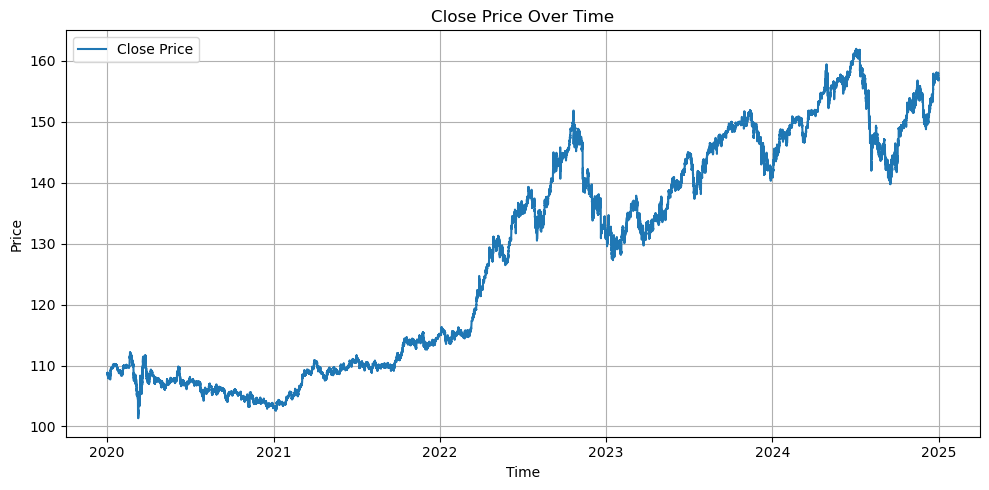

In [6]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['close'], label='Close Price')

plt.title('Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


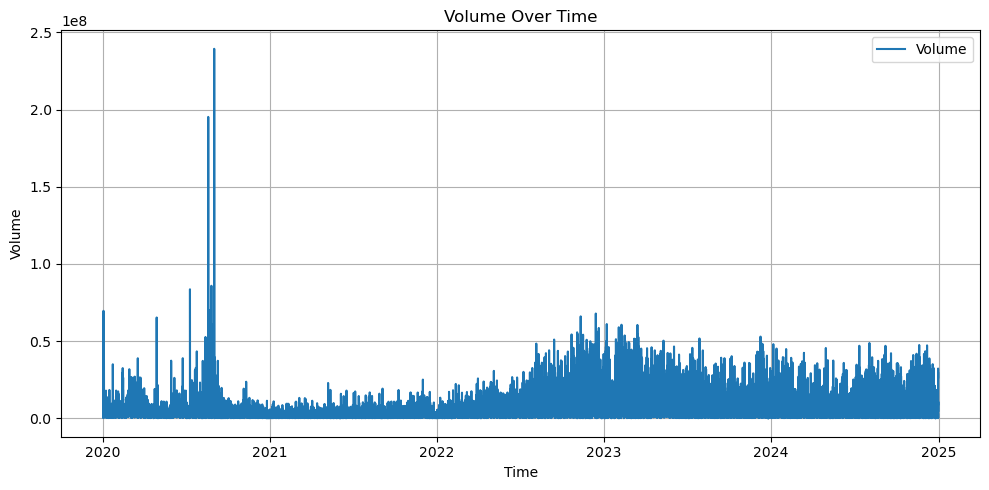

In [7]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['volume'], label='Volume')

plt.title('Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
df.isna().sum() / df.shape[0]

timestamp    0.0
open         0.0
high         0.0
low          0.0
close        0.0
volume       0.0
spread       0.0
dtype: float64

# Volume Feature Engineering

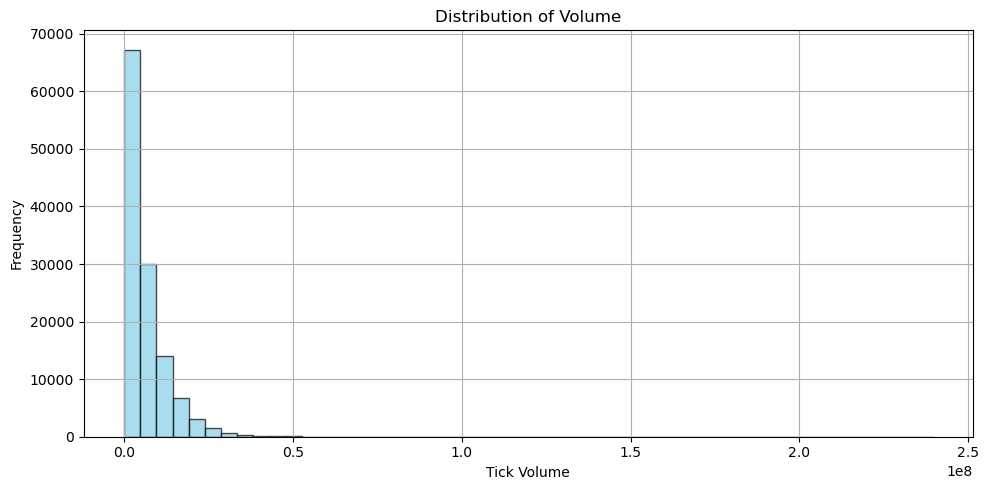

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Tick Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
df['log_volume'] = np.log1p(df['volume'])

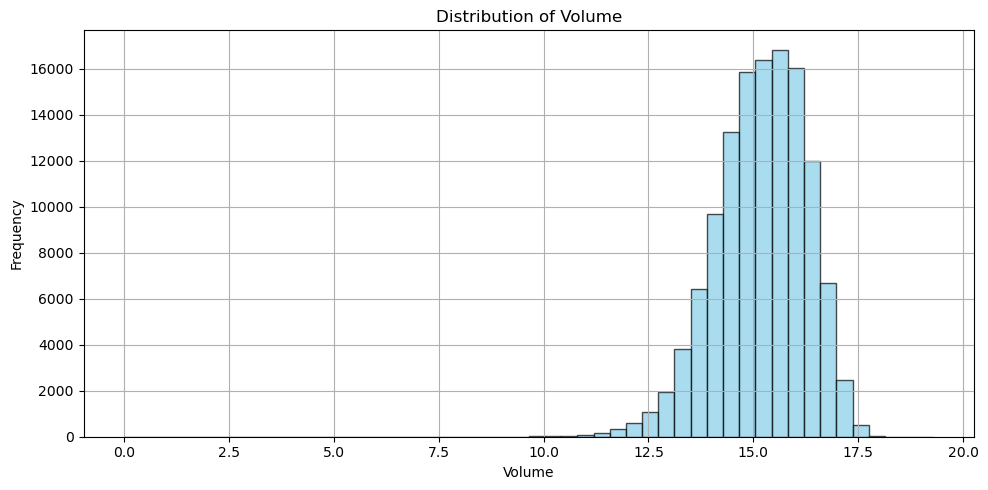

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['log_volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature engineering

## Add delta and return

The original price data is non-stationary, we can convert it into stationary data by calculating the difference between each timeframe as *delta* value.
And we are also adding *return* values that indicates the percentage of grow/drop from the last timeframe.
We will do the following process:
1. calculate delta and returns within each timegroup, note that this will result in adding 1 NaN value for each time group and will be dropped later on.
2. labeling the moving **direction** for each row based on the **return** and a given **threshold**
    ```
    'up' if x > threshold else ('down' if x < -threshold else 'flat')
    ```
3. use a global encoder to encode the **direction**, this column will later on be used as target to train our model.

In [12]:
import pandas as pd
import numpy as np

def add_return_features(df: pd.DataFrame, price_col: str = 'close') -> pd.DataFrame:
    """
    Adds delta, simple return, and log return columns based on a single price column.

    Args:
        df (pd.DataFrame): Input DataFrame with a price column.
        price_col (str): Column name containing price values (default = 'close').

    Returns:
        pd.DataFrame: DataFrame with added columns:
            - {price_col}_delta
            - {price_col}_return
            - {price_col}_log_return
    """
    df = df.copy()
    df[f"{price_col}_delta"] = df[price_col] - df[price_col].shift(1)
    df[f"{price_col}_return"] = df[price_col] / df[price_col].shift(1) - 1
    df[f"{price_col}_log_return"] = np.log(df[price_col] / df[price_col].shift(1))

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df


In [13]:
df = add_return_features(df)

## Plot histgram

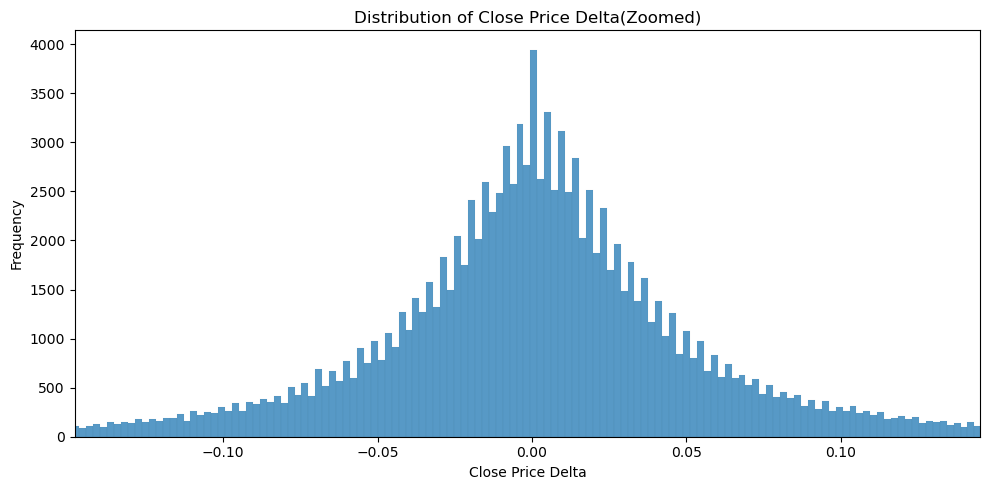

In [14]:
import seaborn as sns

df_copy = df.copy()

low, high = df_copy['close_delta'].quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_delta'])
plt.title("Distribution of Close Price Delta(Zoomed)")
plt.xlabel("Close Price Delta")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

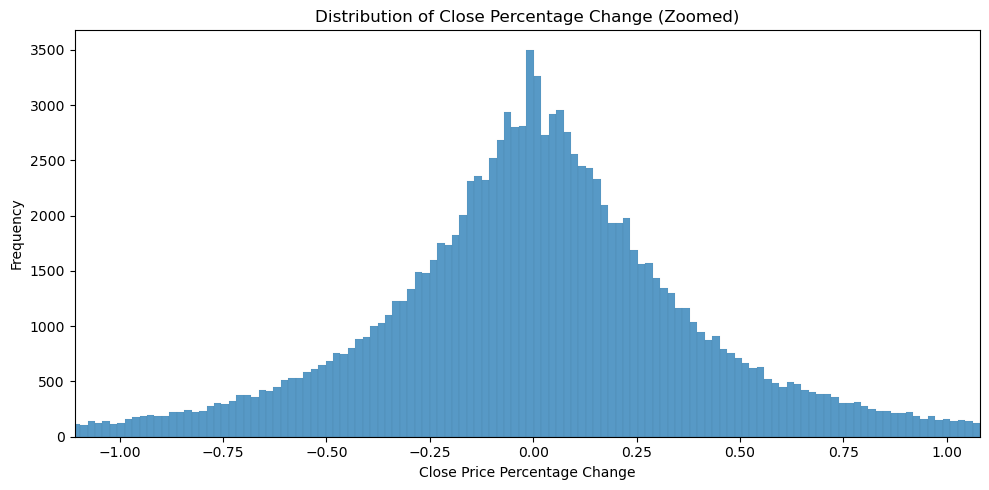

In [15]:
df_copy = df.copy()

low, high = (df_copy['close_return']*1000).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_return']*1000)
plt.title("Distribution of Close Percentage Change (Zoomed)")
plt.xlabel("Close Price Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

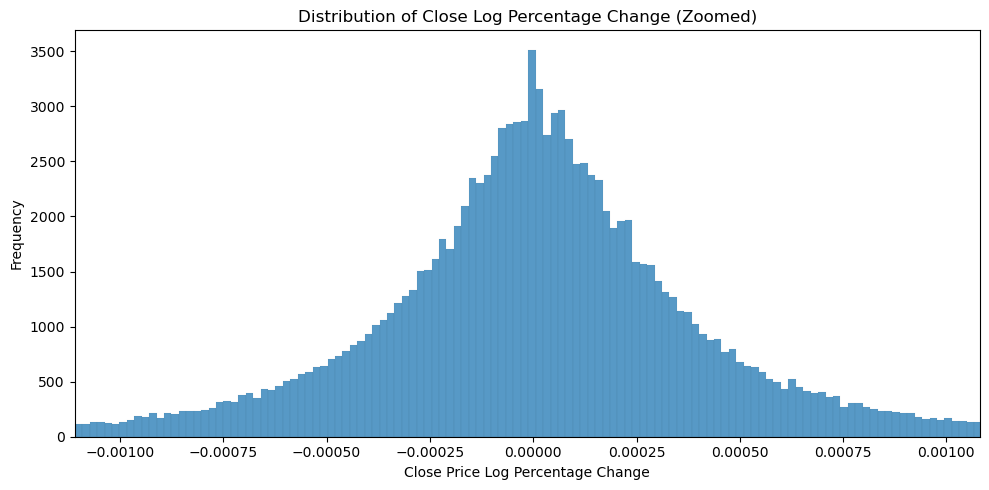

In [16]:
df_copy = df.copy()

low, high = (df_copy['close_log_return']).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_log_return'])
plt.title("Distribution of Close Log Percentage Change (Zoomed)")
plt.xlabel("Close Price Log Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

## Calculate average values

df['ma_21'] = (
    df['close']
    .rolling(window=21, min_periods=1)
    .mean()
)
df.head()

In [17]:
df['ret_mean_5'] = (
    df['close_log_return']
    .rolling(window=5, min_periods=5)
    .mean()
)
df.head()

,timestamp,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5
0,2020-01-01 22:00:00+00:00,108.7580,108.7700,108.6495,108.7450,2.840570e+06,0.025989,14.859516,NaN,NaN,NaN,NaN
1,2020-01-01 22:15:00+00:00,108.7450,108.7480,108.6290,108.7130,4.088100e+05,0.061481,12.921008,-0.0320,-0.000294,-0.000294,NaN
2,2020-01-01 22:30:00+00:00,108.7135,108.7140,108.6740,108.6820,6.953400e+05,0.023646,13.452158,-0.0310,-0.000285,-0.000285,NaN
3,2020-01-01 22:45:00+00:00,108.6820,108.6925,108.6820,108.6925,4.337400e+05,0.027363,12.980203,0.0105,0.000097,0.000097,NaN
4,2020-01-01 23:00:00+00:00,108.6910,108.6910,108.6050,108.6610,1.149910e+06,0.007992,13.955195,-0.0315,-0.000290,-0.000290,NaN


In [18]:
df['ret_mean_10'] = (
    df['close_log_return']
    .rolling(window=10, min_periods=10)
    .mean()
)
df.head()

,timestamp,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10
0,2020-01-01 22:00:00+00:00,108.7580,108.7700,108.6495,108.7450,2.840570e+06,0.025989,14.859516,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 22:15:00+00:00,108.7450,108.7480,108.6290,108.7130,4.088100e+05,0.061481,12.921008,-0.0320,-0.000294,-0.000294,NaN,NaN
2,2020-01-01 22:30:00+00:00,108.7135,108.7140,108.6740,108.6820,6.953400e+05,0.023646,13.452158,-0.0310,-0.000285,-0.000285,NaN,NaN
3,2020-01-01 22:45:00+00:00,108.6820,108.6925,108.6820,108.6925,4.337400e+05,0.027363,12.980203,0.0105,0.000097,0.000097,NaN,NaN
4,2020-01-01 23:00:00+00:00,108.6910,108.6910,108.6050,108.6610,1.149910e+06,0.007992,13.955195,-0.0315,-0.000290,-0.000290,NaN,NaN


## Drop NaN

In [19]:
df.isna().sum()

timestamp            0
open                 0
high                 0
low                  0
close                0
volume               0
spread               0
log_volume           0
close_delta          1
close_return         1
close_log_return     1
ret_mean_5           5
ret_mean_10         10
dtype: int64

In [20]:
df = df.dropna().reset_index(drop=True)

# Saving the file

In [21]:
df.to_pickle(PROCESSED_FILE_PATH)